In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
import pickle
from node2vec import Node2Vec
import pandas as pd

import sys

sys.path.append("../")

from src.futbol_types import TransitionMatrix
from src.utils_CTMC import build_Q, psl_estimator

/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
R_storage = np.load("R_storage.npy")
R_storage.shape

(380, 2, 4, 15, 15)

In [4]:
from src.event_processing import leer_excel

epl = leer_excel("../SampleData/epl.xlsx")

In [5]:
from src.event_processing import (
    separar_partido_del_equipo_en_lineups,
    separar_partido_en_equipo_pov,
    separar_partidos,
)
from src.match_data_extraction import get_lineup_duration


partidos = separar_partidos(epl)

In [6]:
# Store the Duration of each lineup in the R_storage 0, 0

for pi, partido in enumerate(partidos):
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
        for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
            R_storage[pi, ti, li, 0, 0] = get_lineup_duration(lineup)

In [8]:
Q_storage = np.zeros(R_storage.shape)

for pi in range(R_storage.shape[0]):
    for ti in range(R_storage.shape[1]):
        for li in range(R_storage.shape[2]):
            Q_storage[pi, ti, li, 1:, 1:] = build_Q(R_storage[pi, ti, li, 1:, 1:])
            Q_storage[pi, ti, li, 0, :] = R_storage[pi, ti, li, 0, :]
            Q_storage[pi, ti, li, :, 0] = R_storage[pi, ti, li, :, 0]

In [11]:
# Given a R_storage[0, 0, 0] 15x15 matrix
# The R_storage[0, 0, 0, 0, 1:] is the IDs
# The R_storage[0, 0, 0, 1:, 0] is the IDs

# The R_storage[0, 0, 0, 1:, 1:] is the transition matrix


def TM_to_DataFrame(R: TransitionMatrix):

    # Col, Index 0 name is "G"
    # Col, Index 12 name is "L"
    # Col, Index 13 name is "S"

    names = ["G"] + list(R[0, 2:-2]) + ["L", "S"]
    print(names)
    df = pd.DataFrame(R[1:, 1:], index=names, columns=names)

    return df


TM_to_DataFrame(R_storage[0, 0, 0])

['G', 17733.0, 19524.0, 15943.0, 20467.0, 80254.0, 8758.0, 42427.0, 17127.0, 43274.0, 28566.0, 59936.0, 'L', 'S']


,G,17733.0,19524.0,15943.0,20467.0,80254.0,8758.0,42427.0,17127.0,43274.0,28566.0,59936.0,L,S
G,0.0,0.193496,0.354743,0.274120,0.225746,0.435367,0.322494,0.370868,0.177372,0.322494,0.467616,0.080623,0.000000,0.000000
17733.0,0.0,0.000000,0.080623,0.016125,0.016125,0.016125,0.032249,0.032249,0.000000,0.032249,0.048374,0.000000,0.306369,0.016125
19524.0,0.0,0.048374,0.000000,0.048374,0.128998,0.096748,0.128998,0.128998,0.016125,0.128998,0.128998,0.000000,0.467616,0.032249
15943.0,0.0,0.032249,0.048374,0.000000,0.080623,0.016125,0.193496,0.161247,0.386993,0.048374,0.112873,0.016125,0.225746,0.016125
20467.0,0.0,0.016125,0.032249,0.000000,0.000000,0.112873,0.048374,0.048374,0.016125,0.000000,0.000000,0.000000,0.274120,0.016125
80254.0,0.0,0.016125,0.096748,0.096748,0.080623,0.016125,0.128998,0.048374,0.112873,0.080623,0.128998,0.016125,0.370868,0.016125
8758.0,0.0,0.048374,0.322494,0.161247,0.048374,0.112873,0.000000,0.096748,0.209621,0.048374,0.209621,0.000000,0.209621,0.000000
42427.0,0.0,0.048374,0.096748,0.209621,0.032249,0.016125,0.177372,0.000000,0.048374,0.112873,0.128998,0.000000,0.370868,0.000000
17127.0,0.0,0.032249,0.000000,0.370868,0.032249,0.290245,0.112873,0.016125,0.000000,0.016125,0.080623,0.016125,0.080623,0.000000
43274.0,0.0,0.048374,0.048374,0.016125,0.000000,0.048374,0.032249,0.112873,0.000000,0.000000,0.000000,0.000000,0.354743,0.032249


In [13]:
TM_to_DataFrame(Q_storage[0, 0, 0])

['G', 17733.0, 19524.0, 15943.0, 20467.0, 80254.0, 8758.0, 42427.0, 17127.0, 43274.0, 28566.0, 59936.0, 'L', 'S']


,G,17733.0,19524.0,15943.0,20467.0,80254.0,8758.0,42427.0,17127.0,43274.0,28566.0,59936.0,L,S
G,0.0,0.060000,0.110000,0.085000,0.070000,0.135000,0.100000,0.115000,0.055000,0.100000,0.145000,0.025000,0.000000,0.000000
17733.0,0.0,0.000000,0.135135,0.027027,0.027027,0.027027,0.054054,0.054054,0.000000,0.054054,0.081081,0.000000,0.513514,0.027027
19524.0,0.0,0.035714,0.000000,0.035714,0.095238,0.071429,0.095238,0.095238,0.011905,0.095238,0.095238,0.000000,0.345238,0.023810
15943.0,0.0,0.024096,0.036145,0.000000,0.060241,0.012048,0.144578,0.120482,0.289157,0.036145,0.084337,0.012048,0.168675,0.012048
20467.0,0.0,0.028571,0.057143,0.000000,0.000000,0.200000,0.085714,0.085714,0.028571,0.000000,0.000000,0.000000,0.485714,0.028571
80254.0,0.0,0.013333,0.080000,0.080000,0.066667,0.013333,0.106667,0.040000,0.093333,0.066667,0.106667,0.013333,0.306667,0.013333
8758.0,0.0,0.032967,0.219780,0.109890,0.032967,0.076923,0.000000,0.065934,0.142857,0.032967,0.142857,0.000000,0.142857,0.000000
42427.0,0.0,0.038961,0.077922,0.168831,0.025974,0.012987,0.142857,0.000000,0.038961,0.090909,0.103896,0.000000,0.298701,0.000000
17127.0,0.0,0.030769,0.000000,0.353846,0.030769,0.276923,0.107692,0.015385,0.000000,0.015385,0.076923,0.015385,0.076923,0.000000
43274.0,0.0,0.069767,0.069767,0.023256,0.000000,0.069767,0.046512,0.162791,0.000000,0.000000,0.000000,0.000000,0.511628,0.046512


In [25]:
shots_dataset = []

for pi, partido in enumerate(partidos):
    match_id = partido["match_id"].values[0]
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
        for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
            R = R_storage[pi, ti, li, 1:, 1:]
            Q = Q_storage[pi, ti, li, 1:, 1:]
            players = R_storage[pi, ti, li, 0, 2:-2]
            for player_id in players:
                player_pos = np.where(players == player_id)[0][0]

                # Value in R[player_pos, 13] is the ratio of shots to time played for player_id
                shots_dataset.append(
                    {
                        "player_id": player_id,
                        "team_i": ti,
                        "match_id": match_id,
                        "match_i": pi,
                        "lineup_i": li,
                        "shots_prob": Q[player_pos, 13],
                        "shots_ratio": R[player_pos, 13],
                    }
                )

In [ ]:
import pandas as pd

In [26]:
s_ds = pd.DataFrame(shots_dataset)
s_ds["player_id"] = s_ds["player_id"].astype(int)
s_ds

,player_id,team_i,match_id,match_i,lineup_i,shots_prob,shots_ratio
0,17733,0,441999,0,0,0.000000,0.000000
1,19524,0,441999,0,0,0.027027,0.016125
2,15943,0,441999,0,0,0.023810,0.032249
3,20467,0,441999,0,0,0.012048,0.016125
4,80254,0,441999,0,0,0.028571,0.016125
...,...,...,...,...,...,...,...
30740,74235,1,442378,379,3,0.000000,0.000000
30741,106458,1,442378,379,3,0.000000,0.000000
30742,76227,1,442378,379,3,0.000000,0.000000
30743,50471,1,442378,379,3,0.000000,0.000000


In [67]:
s_ds = s_ds[s_ds["shots_prob"] > 0]

<Axes: >

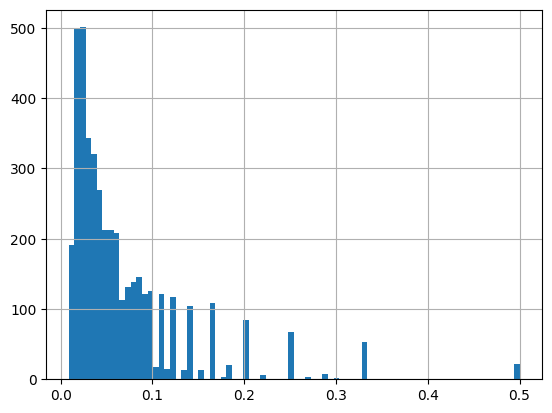

In [68]:
s_ds["shots_prob"].hist(bins=80)

In [69]:
# For each player_id get the Beta Binomial Parameters for the distribution of shots_prob

from scipy.stats import beta

player_ids = s_ds["player_id"].unique()
player_params = []

for player_id in player_ids:

    player_data = s_ds[s_ds["player_id"] == player_id]
    shots = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    if len(shots) < 3:
        continue

    a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)

    player_params.append(
        {
            "player_id": player_id,
            "a": a,
            "b": b,
            # "loc": loc,
            # "scale": scale,
            "count": len(shots),
        }
    )

player_params = pd.DataFrame(player_params)

In [70]:
player_params

,player_id,a,b,count
0,19524,1.077226,11.111839,18
1,15943,1.244024,15.067473,15
2,20467,2.086493,45.153447,15
3,80254,1.997318,21.479373,7
4,8758,1.696920,34.485539,21
...,...,...,...,...
381,56069,1.627049,29.927401,5
382,78315,2.023608,28.583803,5
383,19838,7.681650,80.635601,3
384,16037,52.553535,1392.921991,3


In [71]:
from src.epl_player_data_utils import EPLPlayerData

epl_player_data = EPLPlayerData("../SampleData/players.json")
epl_player_data

EPLPlayerData(../SampleData/players.json): 804 players

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
from tqdm import tqdm
import pickle
from node2vec import Node2Vec
import pandas as pd

import sys

sys.path.append("../")

from src.futbol_types import TransitionMatrix
from src.utils_CTMC import build_Q, psl_estimator

/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
R_storage = np.load("R_storage.npy")
R_storage.shape

(380, 2, 4, 15, 15)

In [ ]:
from src.event_processing import leer_excel

epl = leer_excel("../SampleData/epl.xlsx")

In [ ]:
from src.event_processing import (
    separar_partido_del_equipo_en_lineups,
    separar_partido_en_equipo_pov,
    separar_partidos,
)
from src.match_data_extraction import get_lineup_duration


partidos = separar_partidos(epl)

In [ ]:
# Store the Duration of each lineup in the R_storage 0, 0

for pi, partido in enumerate(partidos):
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
        for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
            R_storage[pi, ti, li, 0, 0] = get_lineup_duration(lineup)

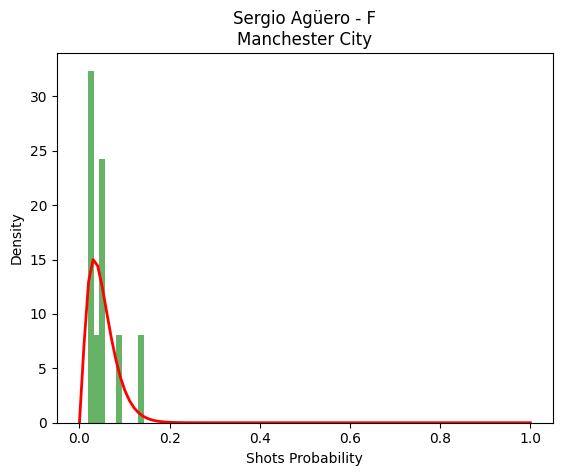

In [146]:
# Plot distribution of shots_prob for a player

import matplotlib.pyplot as plt


def get_team_by_player_id(epl, player_id):
    filtered_epl = epl[epl["player_id"].notna()]
    filtered_epl.loc[:, "player_id"] = filtered_epl["player_id"].astype(int)

    if player_id not in filtered_epl["player_id"].values:
        return None
    # Obtener el team_id correspondiente al player_id
    team_id = filtered_epl[filtered_epl["player_id"] == player_id][
        "home_team_id"
    ].values[0]
    team = filtered_epl[filtered_epl["home_team_id"] == team_id][
        "home_team_name"
    ].values[0]

    return team

def plot_player_shots_prob(s_ds, player_id, ax=None):
    player_data = s_ds[s_ds["player_id"] == player_id]
    shots = player_data[player_data["shots_prob"] > 0]["shots_prob"].values
    position = epl_player_data.get_player_position(player_id)
    team = get_team_by_player_id(epl, player_id)

    if len(shots) < 3:
        return

    # Ajustar la distribución Beta a los datos de shots_prob
    a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)

    if ax is None:
        fig, ax = plt.subplots()

    # Graficar el histograma de shots_prob
    ax.hist(shots, density=True, alpha=0.6, color="g")

    # Crear un rango de valores para la distribución Beta
    x = np.linspace(0, 1, 100)
    y = beta.pdf(x, a, b, loc, scale)

    # Superponer la distribución Beta ajustada
    ax.plot(x, y, "r-", lw=2)

    ax.set_title(f"{epl_player_data.get_player_name(player_id)} - {position}\n{team}")

    ax.set_xlabel("Shots Probability")
    ax.set_ylabel("Density")


plot_player_shots_prob(s_ds, id_sample_player)

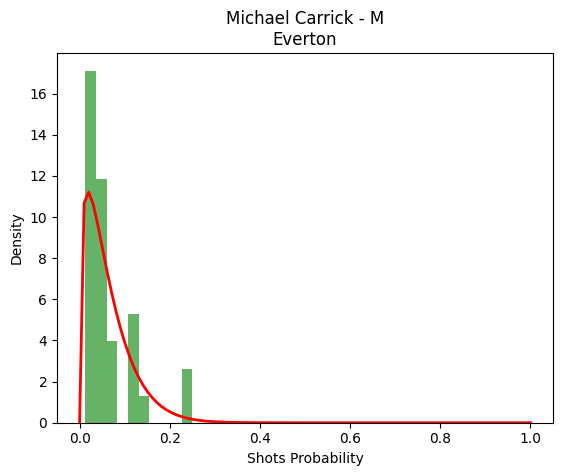

In [147]:
# Player with most appearances
most_id = s_ds["player_id"].value_counts().head(1).index[0]

plot_player_shots_prob(s_ds, most_id)

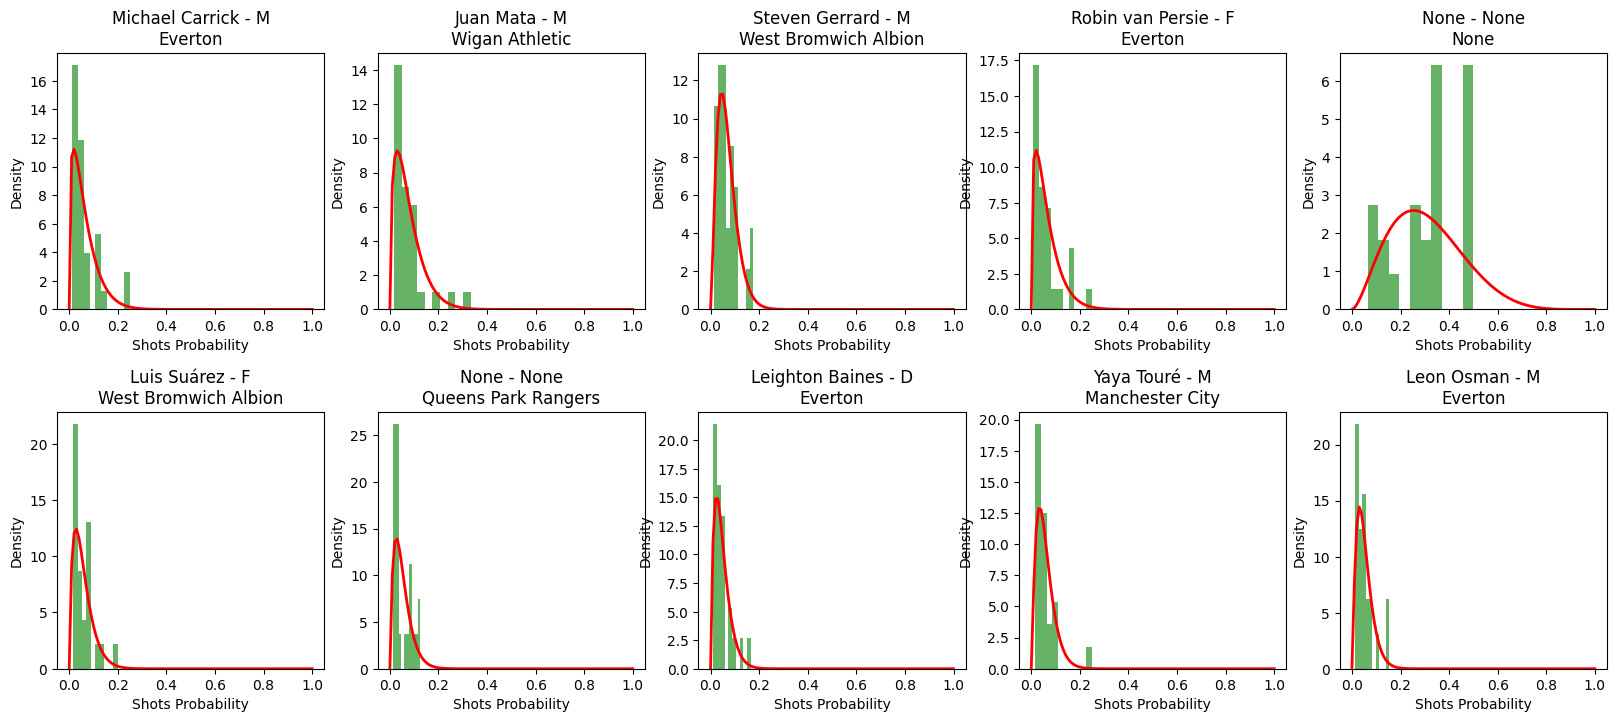

In [148]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
top = s_ds["player_id"].value_counts().head(10).index
for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top[i], ax)

plt.subplots_adjust(hspace=0.4)

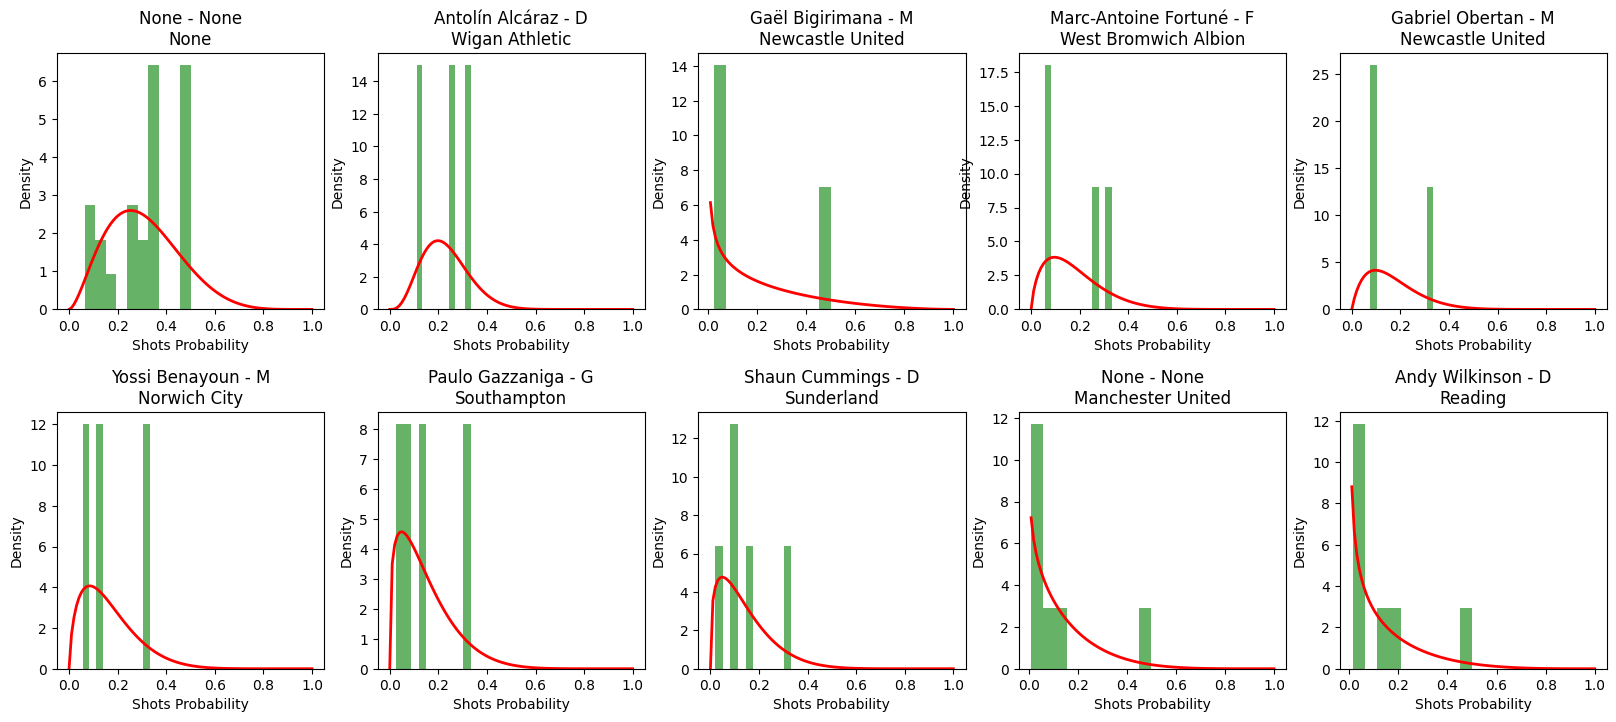

In [149]:
# Find top 10 with beta dist most skewed to the right
player_params["skew"] = player_params["a"] / (player_params["a"] + player_params["b"])
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
top = player_params.sort_values("skew", ascending=False).head(10)["player_id"]
for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top.values[i], ax)

plt.subplots_adjust(hspace=0.4)

In [150]:
player_params["position"] = player_params["player_id"].apply(
    lambda x: epl_player_data.get_player_position(int(x))
)

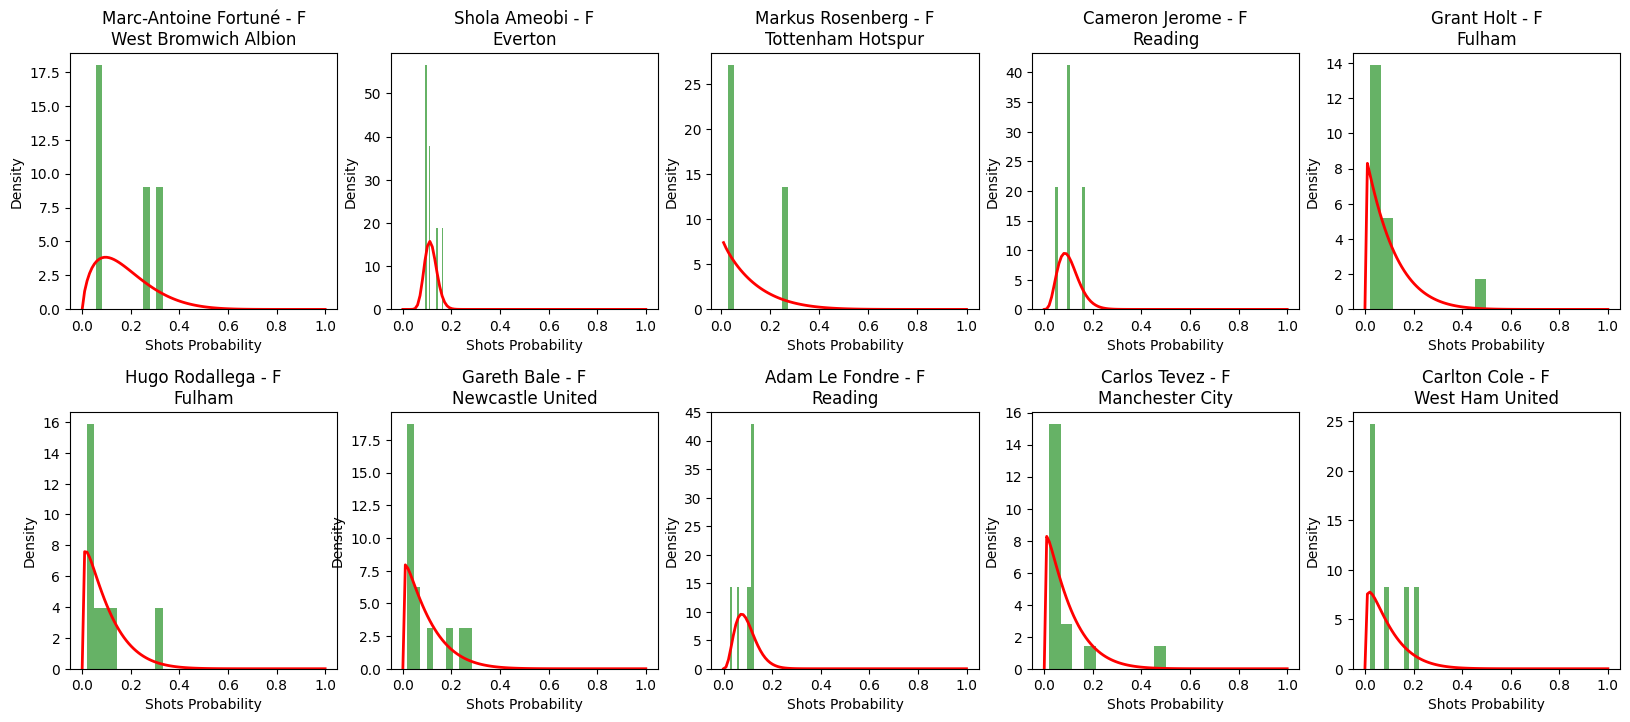

In [151]:
# Top Forwards
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

top = player_params[player_params["position"] == "F"].sort_values("skew", ascending=False).head(10)["player_id"]

for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top.values[i], ax)

plt.subplots_adjust(hspace=0.4)

Text(0.5, 0.98, 'Top 20 Forwards with most skewed Beta Distribution of shots_prob')

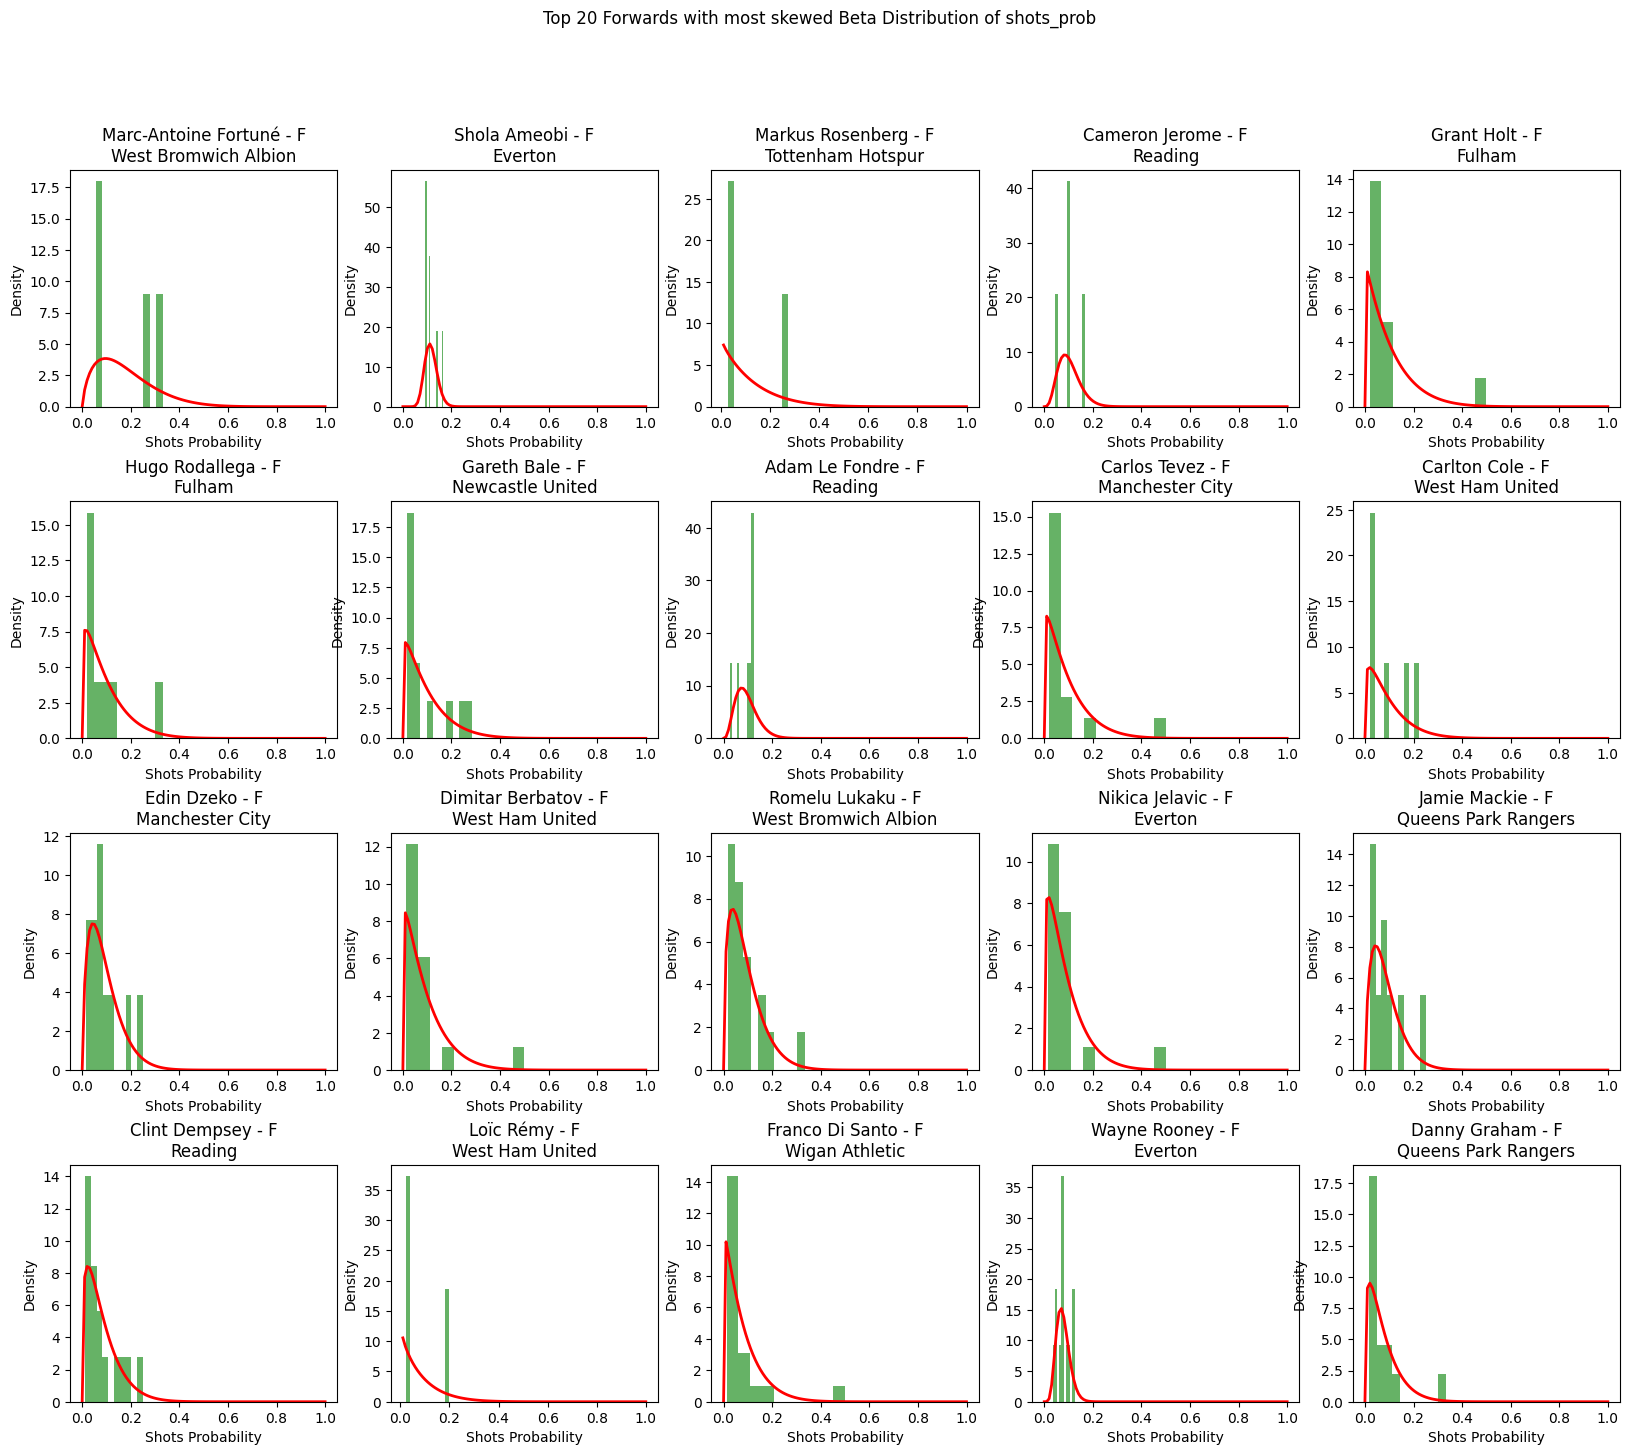

In [152]:
# Top Forwards
fig, axs = plt.subplots(4, 5, figsize=(20, 16))

top = (
    player_params[player_params["position"] == "F"]
    .sort_values("skew", ascending=False)
    .head(20)["player_id"]
)

for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top.values[i], ax)

plt.subplots_adjust(hspace=0.4)

fig.suptitle("Top 20 Forwards with most skewed Beta Distribution of shots_prob")

In [158]:
s_ds["position"] = s_ds["player_id"].apply(
    lambda x: epl_player_data.get_player_position(int(x))
)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_67409/711550679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_ds["position"] = s_ds["player_id"].apply(


19556 David Jones D 0.00046040059121303656
78091 Gastón Ramírez M 0.0007322132763427358
19534 Javi García M 0.001162132527675247
28491 Ali Al Habsi G 0.0016331123999858421
15976 Jos Hooiveld D 0.0021446880972890714
43191 Lucas Leiva M 0.002198328235607519
8378 Leon Osman M 0.0022254406020906226
19419 Gary Cahill D 0.0026782084631185032
54102 Jack Wilshere M 0.00398137241331431
3736 John O'Shea D 0.005695317892845296


Text(0.5, 0.98, 'Players similar to Sergio Agüero')

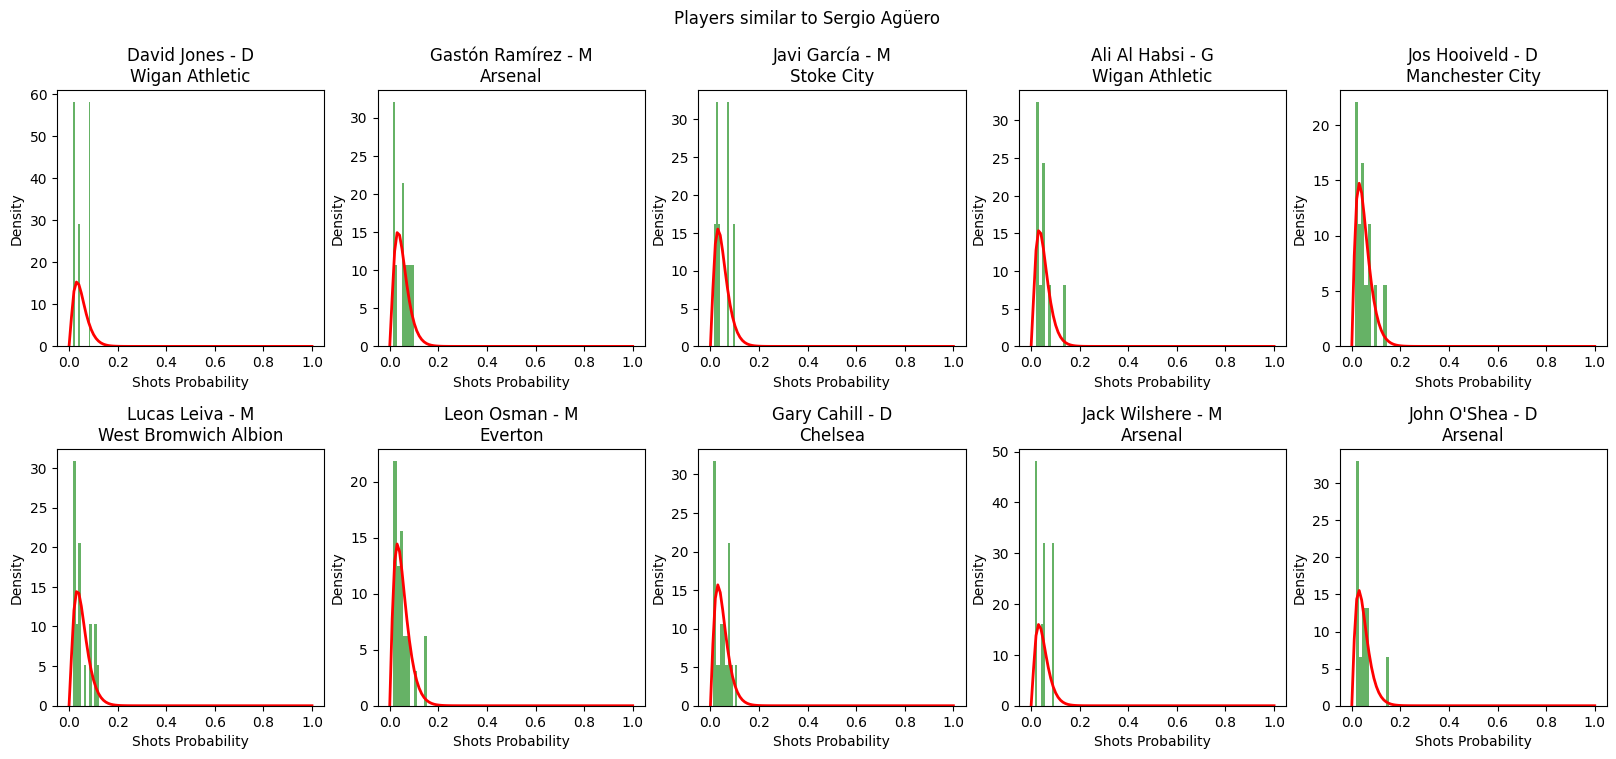

In [161]:
from scipy.special import betaln, psi


def get_beta_binom_params(s_ds):
    player_ids = s_ds["player_id"].unique()
    player_params = []

    for player_id in player_ids:
        player_data = s_ds[s_ds["player_id"] == player_id]
        shots = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

        if len(shots) < 3:
            continue

        a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)

        player_params.append(
            {
                "player_id": player_id,
                "a": a,
                "b": b,
                "count": len(shots),
            }
        )

    return pd.DataFrame(player_params)


def kl_divergence_beta(a1, b1, a2, b2):
    # Fórmula de la divergencia KL para distribuciones Beta
    return (
        betaln(a2, b2)
        - betaln(a1, b1)
        + (a1 - a2) * (psi(a1) - psi(a1 + b1))
        + (b1 - b2) * (psi(b1) - psi(a1 + b1))
    )


def find_similar_players(s_ds, target_player_id, same_position=False):
    player_params = get_beta_binom_params(s_ds)
    player_params["position"] = player_params["player_id"].apply(
        lambda x: epl_player_data.get_player_position(int(x))
    )
    
    target_params = player_params[player_params["player_id"] == target_player_id].iloc[
        0
    ]

    if same_position:
        target_position = s_ds[s_ds["player_id"] == target_player_id][
            "position"
        ].values[0]
        player_params = player_params[player_params["position"] == target_position]

    distances = []
    for _, row in player_params.iterrows():
        if row["player_id"] == target_player_id:
            continue
        dist = kl_divergence_beta(
            target_params["a"], target_params["b"], row["a"], row["b"]
        )
        distances.append((row["player_id"], dist))

    distances.sort(key=lambda x: x[1])
    return distances


# Ejemplo de uso
sample_player = "Sergio Agüero"
id_sample_player = epl_player_data.get_player_id_by_name(sample_player)

similar_players = find_similar_players(s_ds, id_sample_player)

for player_id, dist in similar_players[:10]:
    print(
        player_id,
        epl_player_data.get_player_name(int(player_id)),
        epl_player_data.get_player_position(int(player_id)),
        dist,
    )

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
top = [int(x[0]) for x in similar_players[:10]]
for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top[i], ax)

plt.subplots_adjust(hspace=0.4)
fig.suptitle(f"Players similar to {sample_player}")

Text(0, 0.5, 'Density')

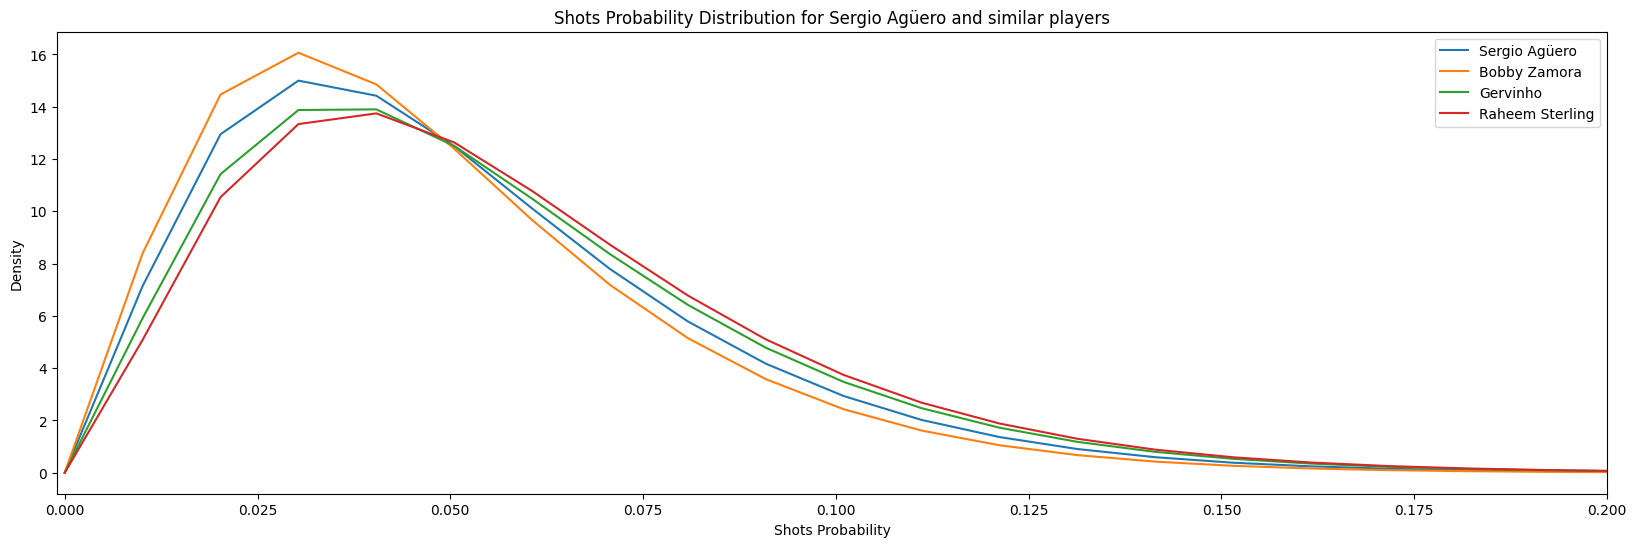

In [172]:
# Plot overlayed shots_prob for similar players

fig, ax = plt.subplots(figsize=(20, 6))

for player_id, _ in [(id_sample_player, None)] + similar_players[:3]:

    player_data = s_ds[s_ds["player_id"] == int(player_id)]
    shots = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)

    x = np.linspace(0, 1, 100)
    y = beta.pdf(x, a, b, loc, scale)

    ax.plot(x, y, label=epl_player_data.get_player_name(int(player_id)))

ax.legend()
ax.set_xlim(-0.001, 0.2)
ax.set_title(f"Shots Probability Distribution for {sample_player} and similar players")
ax.set_xlabel("Shots Probability")
ax.set_ylabel("Density")


4570 Bobby Zamora F 0.00651507148624933
43274 Gervinho F 0.006722609403886443
103955 Raheem Sterling F 0.01597415364611983
59125 Connor Wickham F 0.022413184271040693
14402 Fernando Torres F 0.023954412914340972
42758 Papiss Cissé F 0.02502238624020304
40755 Daniel Sturridge F 0.030415766487300933
20467 Theo Walcott F 0.035441659488541305
39336 Luis Suárez F 0.04154077601240891
20452 Shane Long F 0.04323022819169342


Text(0.5, 0.98, 'Players similar to Sergio Agüero in the same position')

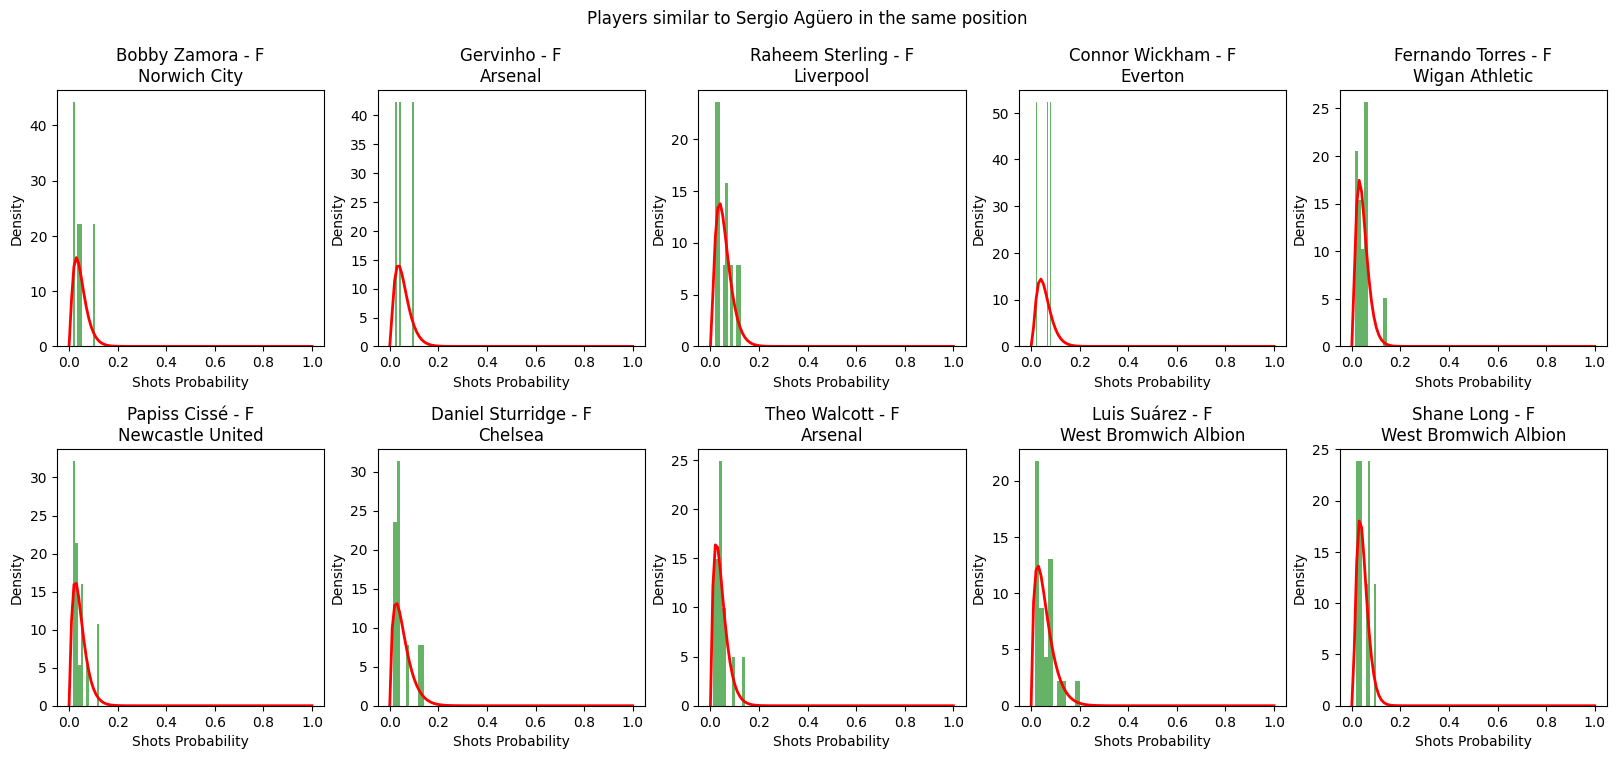

In [174]:
# Same position
similar_players = find_similar_players(s_ds, id_sample_player, same_position=True)

for player_id, dist in similar_players[:10]:
    print(
        player_id,
        epl_player_data.get_player_name(int(player_id)),
        epl_player_data.get_player_position(int(player_id)),
        dist,
    )

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
top = [int(x[0]) for x in similar_players[:10]]

# Get max shots_prob for all players and adjust the x-axis
max_shots_prob = s_ds["shots_prob"].max()

for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top[i], ax)

    # ax.set_xlim(-0.001, max_shots_prob * 1.1)

plt.subplots_adjust(hspace=0.4)
fig.suptitle(f"Players similar to {sample_player} in the same position")

6240 Shola Ameobi F 7.083648364555886
43020 Chicharito F 2.75115986357466
18804 Cameron Jerome F 1.1282721887570935
14279 Marc-Antoine Fortuné F 1.1185594335764208
13017 Wayne Rooney F 1.0366493789549556
19163 Adam Le Fondre F 0.7382967041591146
26806 Markus Rosenberg F 0.4930785969185618
5741 Grant Holt F 0.39893529221933255
36903 Gareth Bale F 0.37365507375221574
37334 Hugo Rodallega F 0.3707425972935028


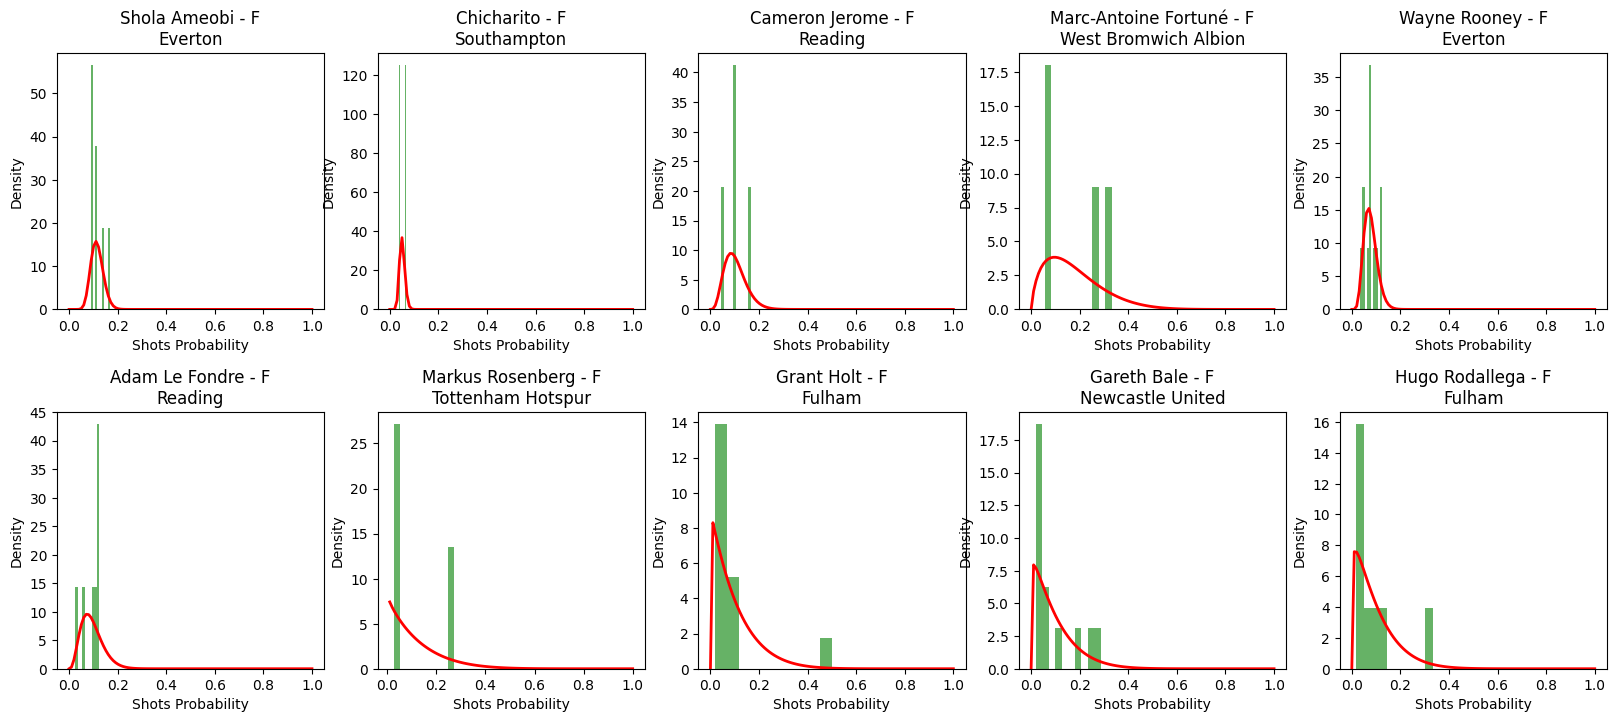

In [175]:
# Find most dissimilar player

def find_dissimilar_players(s_ds, target_player_id, same_position=False):
    return find_similar_players(s_ds, target_player_id, same_position=True)[::-1]

# Plot most dissimilar player to sample player
dissimilar_players = find_dissimilar_players(s_ds, id_sample_player)

for player_id, dist in dissimilar_players[:10]:
    print(
        player_id,
        epl_player_data.get_player_name(int(player_id)),
        epl_player_data.get_player_position(int(player_id)),
        dist,
    )

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
top = [int(x[0]) for x in dissimilar_players[:10]]
for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top[i], ax)

plt.subplots_adjust(hspace=0.4)